In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, isnull, sum as spark_sum, lower, regexp_replace
from pyspark.sql.functions import length, size, split, count, udf, explode
from pyspark.ml.feature import Tokenizer, StopWordsRemover, HashingTF, IDF, StringIndexer
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml import Pipeline
from textblob import TextBlob
from pyspark.sql.types import StringType, ArrayType
import nltk
from nltk.stem import PorterStemmer
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
spark = SparkSession.builder \
    .appName("SentimentAnalysisEcommerce") \
    .config("spark.executor.memory", "6g") \
    .config("spark.driver.memory", "6g") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.warehouse.dir", "file:///C:/tmp/spark-warehouse") \
    .enableHiveSupport() \
    .getOrCreate()

In [3]:
spark

**Eksplorasi Data**

In [4]:
df = spark.read.csv("Books_5_part5.csv", header=True, inferSchema=True)

df.show()

+--------------------+--------------------+--------------------+--------------------+--------------------+
|                asin|          reviewText|             overall|            category|             summary|
+--------------------+--------------------+--------------------+--------------------+--------------------+
|          1760290335|I couldn't put it...|                 5.0|             Books_5|          Great Read|
|          1760290335|This reads like a...|                 1.0|             Books_5|This reads like a...|
|          1760290335|Great story. Shar...|                 5.0|             Books_5|Great story. Shar...|
|          1760290335|A story of fiftee...|                 5.0|             Books_5|A book everyone s...|
|          1760290335|I enjoy reading a...|                 4.0|             Books_5|          Four Stars|
|          1760290335|An intriguing boo...|                 5.0|             Books_5|Support those who...|
|          1743601654|I do not really

In [5]:
df.printSchema()

root
 |-- asin: string (nullable = true)
 |-- reviewText: string (nullable = true)
 |-- overall: string (nullable = true)
 |-- category: string (nullable = true)
 |-- summary: string (nullable = true)



In [6]:
df.select(spark_sum(isnull(col("reviewText")).cast("int")).alias("null_count")).show()

+----------+
|null_count|
+----------+
|    874947|
+----------+



In [7]:
total_rows = df.count()
unique_rows = df.dropDuplicates().count()
duplicates = total_rows - unique_rows

print(f"Jumlah data duplikat: {duplicates}")

Jumlah data duplikat: 203741


In [8]:
df = df.withColumn("char_count", length("reviewText"))
df = df.withColumn("word_count", size(split("reviewText", " ")))

df.select("char_count", "word_count").describe().show()

+-------+------------------+------------------+
|summary|        char_count|        word_count|
+-------+------------------+------------------+
|  count|           6742337|           7617284|
|   mean|172.99263296984412|28.466259496166874|
| stddev| 210.3791906827953|37.877597872611176|
|    min|                 1|                -1|
|    max|             12006|              2099|
+-------+------------------+------------------+



**Data Preprocessing**

In [9]:
df = df.drop("asin", "category", "summary")

In [10]:
df.show(5)

+--------------------+-------+----------+----------+
|          reviewText|overall|char_count|word_count|
+--------------------+-------+----------+----------+
|I couldn't put it...|    5.0|       115|        21|
|This reads like a...|    1.0|       108|        21|
|Great story. Shar...|    5.0|       154|        28|
|A story of fiftee...|    5.0|       838|       157|
|I enjoy reading a...|    4.0|        92|        16|
+--------------------+-------+----------+----------+
only showing top 5 rows



In [11]:
df_cleaned = df.dropna(subset=["reviewText"])

In [12]:
df_cleaned.select(spark_sum(isnull(col("reviewText")).cast("int")).alias("null_count")).show()

+----------+
|null_count|
+----------+
|         0|
+----------+



In [13]:
df_cleaned = df_cleaned.dropDuplicates()

In [14]:
total_rows = df_cleaned.count()
unique_rows = df_cleaned.dropDuplicates().count()
duplicates = total_rows - unique_rows

print(f"Jumlah data duplikat: {duplicates}")

Jumlah data duplikat: 0


In [15]:
df_cleaned.count()

5769068

In [52]:
df_clean = df_cleaned.withColumn("clean_text", lower(col("reviewText")))
df_clean = df_clean.withColumn("clean_text", regexp_replace("clean_text", "[^a-zA-Z\s]", ""))

In [53]:
df_clean.show(5)

+--------------------+--------------------+----------+----------+--------------------+
|          reviewText|             overall|char_count|word_count|          clean_text|
+--------------------+--------------------+----------+----------+--------------------+
| and where there ...| they are obvious...|        35|         9| and where there ...|
| she is surprised...|         Mark Tipene|        55|        12| she is surprised...|
|Pictures are love...|                 1.0|        71|        12|pictures are love...|
|Like most Lonely ...|                 3.0|       447|        79|like most lonely ...|
|    Ariah Larochelle| happened to be w...|        17|         3|    ariah larochelle|
+--------------------+--------------------+----------+----------+--------------------+
only showing top 5 rows



In [54]:
tokenizer = Tokenizer(inputCol="clean_text", outputCol="tokens")
df_token = tokenizer.transform(df_clean)

In [55]:
df_token.show(5)

+--------------------+--------------------+----------+----------+--------------------+--------------------+
|          reviewText|             overall|char_count|word_count|          clean_text|              tokens|
+--------------------+--------------------+----------+----------+--------------------+--------------------+
| and where there ...| they are obvious...|        35|         9| and where there ...|[, and, where, th...|
| she is surprised...|         Mark Tipene|        55|        12| she is surprised...|[, she, is, surpr...|
|Pictures are love...|                 1.0|        71|        12|pictures are love...|[pictures, are, l...|
|Like most Lonely ...|                 3.0|       447|        79|like most lonely ...|[like, most, lone...|
|    Ariah Larochelle| happened to be w...|        17|         3|    ariah larochelle|[, ariah, laroche...|
+--------------------+--------------------+----------+----------+--------------------+--------------------+
only showing top 5 rows



In [56]:
remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_words")
df_filtered = remover.transform(df_token)

In [57]:
df_filtered.show(5)

+--------------------+--------------------+----------+----------+--------------------+--------------------+--------------------+
|          reviewText|             overall|char_count|word_count|          clean_text|              tokens|      filtered_words|
+--------------------+--------------------+----------+----------+--------------------+--------------------+--------------------+
| and where there ...| they are obvious...|        35|         9| and where there ...|[, and, where, th...|        [, one, two]|
| she is surprised...|         Mark Tipene|        55|        12| she is surprised...|[, she, is, surpr...|[, surprised, lea...|
|Pictures are love...|                 1.0|        71|        12|pictures are love...|[pictures, are, l...|[pictures, lovely...|
|Like most Lonely ...|                 3.0|       447|        79|like most lonely ...|[like, most, lone...|[like, lonely, pl...|
|    Ariah Larochelle| happened to be w...|        17|         3|    ariah larochelle|[, ariah, l

In [58]:
stemmer = PorterStemmer()

def stemming_udf(words):
    return [stemmer.stem(word) for word in words]

In [59]:
stem_udf = udf(stemming_udf, ArrayType(StringType()))
df_stemmed = df_filtered.withColumn("stemmed_words", stem_udf(col("filtered_words")))

In [60]:
df_stemmed.show(10, truncate=True)

+--------------------+--------------------+----------+----------+--------------------+--------------------+--------------------+--------------------+
|          reviewText|             overall|char_count|word_count|          clean_text|              tokens|      filtered_words|       stemmed_words|
+--------------------+--------------------+----------+----------+--------------------+--------------------+--------------------+--------------------+
| and where there ...| they are obvious...|        35|         9| and where there ...|[, and, where, th...|        [, one, two]|        [, one, two]|
| she is surprised...|         Mark Tipene|        55|        12| she is surprised...|[, she, is, surpr...|[, surprised, lea...|[, surpris, learn...|
|Pictures are love...|                 1.0|        71|        12|pictures are love...|[pictures, are, l...|[pictures, lovely...|[pictur, love, be...|
|Like most Lonely ...|                 3.0|       447|        79|like most lonely ...|[like, most, l

In [61]:
df_done = df_stemmed.select(explode("filtered_words").alias("word"))
df_done.groupBy("word").count().orderBy("count", ascending=False).show(10)

+------+-------+
|  word|  count|
+------+-------+
|      |6806617|
|  book|2943366|
|  read|1480552|
| story|1167593|
|   one| 936200|
|  love| 813609|
| great| 699959|
|  good| 672733|
|series| 657148|
| books| 620939|
+------+-------+
only showing top 10 rows



In [62]:
def get_sentiment(text):
    try:
        polarity = TextBlob(text).sentiment.polarity
        if polarity > 0:
            return "Positif"
        elif polarity < 0:
            return "Negatif"
        else:
            return "Netral"
    except:
        return "Tidak Valid"

In [63]:
sentiment_udf = udf(get_sentiment, StringType())
df_labeled = df_stemmed.withColumn("sentiment", sentiment_udf(col("clean_text")))

df_labeled.select("reviewText", "sentiment").show(10, truncate=True)

+--------------------+---------+
|          reviewText|sentiment|
+--------------------+---------+
| and where there ...|   Netral|
| she is surprised...|  Positif|
|Pictures are love...|  Positif|
|Like most Lonely ...|  Positif|
|    Ariah Larochelle|   Netral|
| I looked upon th...|  Positif|
| if in San Francisco|   Netral|
|             address|   Netral|
|the spiral bound ...|  Positif|
|           rock gods|   Netral|
+--------------------+---------+
only showing top 10 rows



In [28]:
df_sentiment_count = df_labeled.groupBy("sentiment").count()
df_sentiment_count.show()

+---------+-------+
|sentiment|  count|
+---------+-------+
|  Positif|4027684|
|  Negatif| 668914|
|   Netral|1072470|
+---------+-------+



**Visualisasi**

In [29]:
df_sentiment_pd = df_sentiment_count.toPandas()

order = ['Negatif', 'Netral', 'Positif']
df_sentiment_pd['sentiment'] = pd.Categorical(df_sentiment_pd['sentiment'], categories=order, ordered=True)
df_sentiment_pd = df_sentiment_pd.sort_values('sentiment')

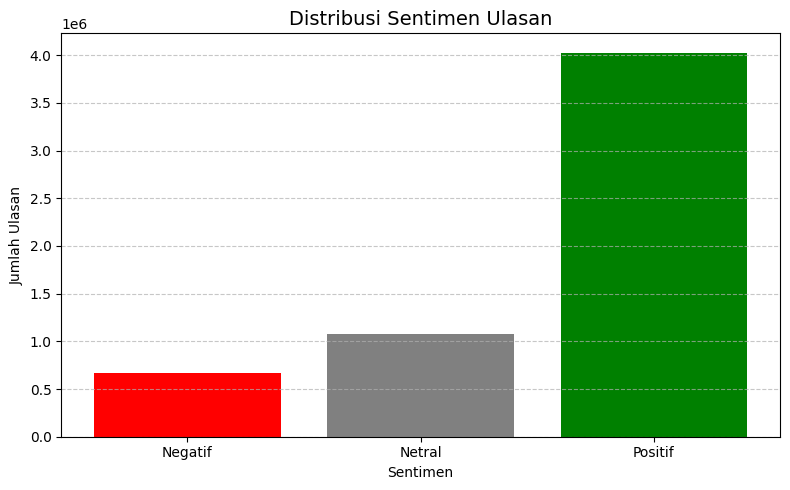

In [30]:
plt.figure(figsize=(8, 5))
plt.bar(df_sentiment_pd['sentiment'], df_sentiment_pd['count'],
        color=['red', 'gray', 'green'])

plt.title("Distribusi Sentimen Ulasan", fontsize=14)
plt.xlabel("Sentimen")
plt.ylabel("Jumlah Ulasan")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [35]:
df_positif = df_labeled.filter(df_labeled.sentiment == "Positif").sample(withReplacement=False, fraction=0.1, seed=42)
df_netral  = df_labeled.filter(df_labeled.sentiment == "Netral").sample(withReplacement=False, fraction=0.1, seed=42)
df_negatif = df_labeled.filter(df_labeled.sentiment == "Negatif").sample(withReplacement=False, fraction=0.1, seed=42)

df_positif_pd = df_positif.select("clean_text").toPandas()
df_netral_pd  = df_netral.select("clean_text").toPandas()
df_negatif_pd = df_negatif.select("clean_text").toPandas()

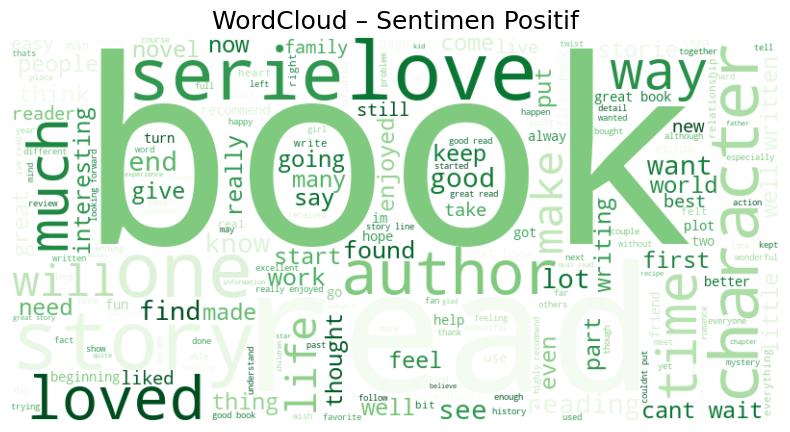

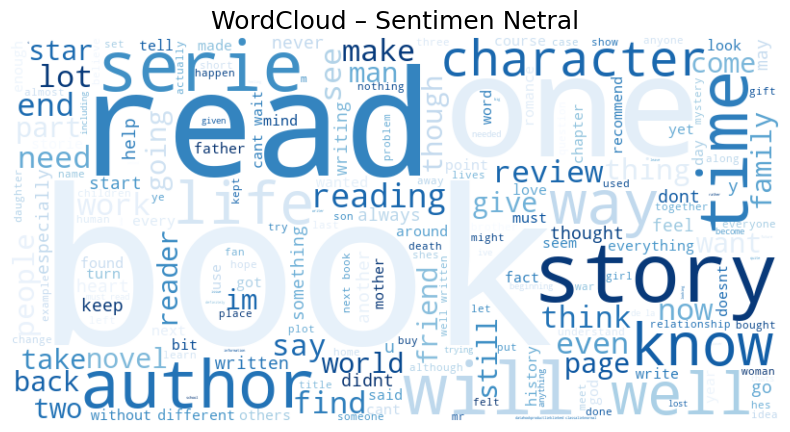

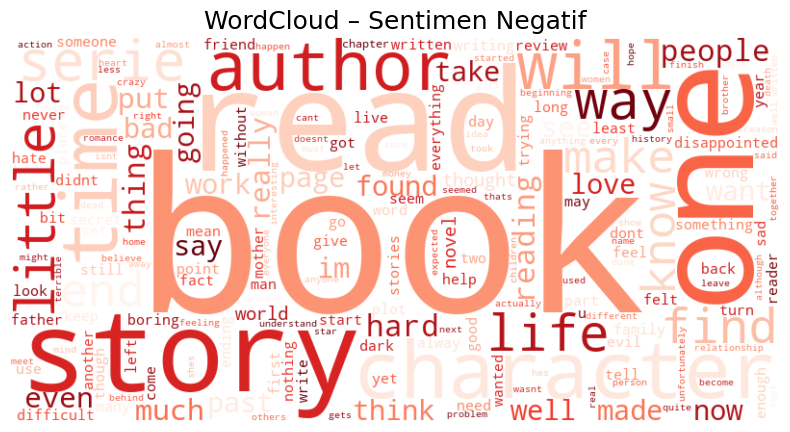

In [36]:
def plot_wordcloud(text_series, title, color='black'):
    text = " ".join(text_series.dropna().tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white', colormap=color).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(title, fontsize=18)
    plt.show()

plot_wordcloud(df_positif_pd['clean_text'], "WordCloud – Sentimen Positif", color='Greens')
plot_wordcloud(df_netral_pd['clean_text'], "WordCloud – Sentimen Netral", color='Blues')
plot_wordcloud(df_negatif_pd['clean_text'], "WordCloud – Sentimen Negatif", color='Reds')

In [29]:
train_data, test_data = df_labeled.randomSplit([0.8, 0.2], seed=42)

In [30]:
hashingTF = HashingTF(inputCol="stemmed_words", outputCol="rawFeatures", numFeatures=1000)
idf = IDF(inputCol="rawFeatures", outputCol="features")
label_indexer = StringIndexer(inputCol="sentiment", outputCol="label")

**Modelling**

In [31]:
lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=20)

pipeline_lr = Pipeline(stages=[label_indexer, hashingTF, idf, lr])
model_lr = pipeline_lr.fit(train_data)
pred_lr = model_lr.transform(test_data)

In [32]:
rf = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=100)

pipeline_rf = Pipeline(stages=[label_indexer, hashingTF, idf, rf])
model_rf = pipeline_rf.fit(train_data)
pred_rf = model_rf.transform(test_data)

**Evaluasi**

In [33]:
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction")

def evaluate_model(predictions, model_name):
    acc = evaluator.evaluate(predictions, {evaluator.metricName: "accuracy"})
    prec = evaluator.evaluate(predictions, {evaluator.metricName: "weightedPrecision"})
    rec = evaluator.evaluate(predictions, {evaluator.metricName: "weightedRecall"})
    f1 = evaluator.evaluate(predictions, {evaluator.metricName: "f1"})

    print(f"\nHasil Evaluasi: {model_name}")
    print(f"Akurasi    : {acc:.4f}")
    print(f"Precision  : {prec:.4f}")
    print(f"Recall     : {rec:.4f}")
    print(f"F1-Score   : {f1:.4f}")

In [34]:
evaluate_model(pred_lr, "Logistic Regression")
evaluate_model(pred_rf, "Random Forest")


Hasil Evaluasi: Logistic Regression
Akurasi    : 0.8147
Precision  : 0.8004
Recall     : 0.8147
F1-Score   : 0.7979

Hasil Evaluasi: Random Forest
Akurasi    : 0.6979
Precision  : 0.4870
Recall     : 0.6979
F1-Score   : 0.5737


In [35]:
spark.stop()